In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Load full data for a single channel
df = pd.read_csv("../data/run0006/layer1_x0_y0.csv")
time_cols = [c for c in df.columns if c.startswith("t")]
waveforms = df[time_cols].values
original_energies = df["energy"].values  # or the correct column name

In [5]:
# Parameters from the C++ config
params_c4_reference = {
    "sampling": 10.0,
    "smoothing_L": 200.0,
    "MWD_length": 400.0,
    "decay_time": 2300.0,
    "MWD_trace_start": 500.0,
    "MWD_trace_stop": 2000.0,
    "MWD_amp_start": 1350.0,
    "MWD_amp_stop": 1400.0,
    "MWD_baseline_start": 500.0,
    "MWD_baseline_stop": 650.0,
}

In [6]:
def MWD(trace, params, baseline_corr=True):
    """
    Python translation of MWD algorithm from C4 LisaRaw2Ana.cxx
    Returns MWD trace, energy, and flatness.
    """

    sampling = params["sampling"]
    smoothing_L = params["smoothing_L"]
    MWD_length = params["MWD_length"]
    decay_time = params["decay_time"]

    # Index conversions
    LL = int(smoothing_L / sampling)
    MM = int(MWD_length / sampling)
    tau = decay_time / sampling

    k0 = int(params["MWD_trace_start"] / sampling)
    kend = int(params["MWD_trace_stop"] / sampling)

    amp_start_idx = int(params["MWD_amp_start"] / sampling) - k0
    amp_stop_idx = int(params["MWD_amp_stop"] / sampling) - k0

    baseline_start_idx = int(params["MWD_baseline_start"] / sampling) - k0
    baseline_stop_idx = int(params["MWD_baseline_stop"] / sampling) - k0
    
    # Baseline correction
    baseline = np.mean(trace[20:150]) if baseline_corr else 0.0
    trace_febex_0 = (np.array(trace) - baseline) / 8.0
    
    # MWD trace calculation
    trace_mwd = []
    for kk in range(k0, min(kend, len(trace))):
        DM = 0.0
        sum0 = None
        for j in range(kk - LL, kk):
            if j < 1 or (j - MM) < 0 or j >= len(trace_febex_0):
                continue
            if sum0 is None:
                sum0 = np.sum(trace_febex_0[max(0, j - MM):j])
            else:
                if (j - MM - 1) >= 0:
                    sum0 -= trace_febex_0[j - MM - 1]
                sum0 += trace_febex_0[j - 1]
            DM += trace_febex_0[j] - trace_febex_0[j - MM] + sum0 / tau
        trace_mwd.append(DM / LL)

    trace_mwd = np.array(trace_mwd)

    # Energy and flatness calculation
    valid = (
        0 <= amp_start_idx < amp_stop_idx <= len(trace_mwd)
        and 0 <= baseline_start_idx < baseline_stop_idx <= len(trace_mwd)
    )

    if valid:
        energy_flat = np.mean(trace_mwd[amp_start_idx:amp_stop_idx])
        energy_base = np.mean(trace_mwd[baseline_start_idx:baseline_stop_idx])
        energy = abs(energy_flat - energy_base)
        flat_top = trace_mwd[amp_start_idx:amp_stop_idx]
        flatness = np.std(flat_top) / np.mean(flat_top)
    else:
        energy = np.nan
        flatness = np.nan

    return trace_mwd, energy, flatness

In [7]:
def plot_mwd_batch_diagnostics(indices, waveforms, params):
    energies = []
    flatnesses = []
    mwd_traces = []
    raw_traces = []

    sampling = params["sampling"]
    k0 = int(params["MWD_trace_start"] / sampling)
    amp_start = int(params["MWD_amp_start"] / sampling) - k0
    amp_stop = int(params["MWD_amp_stop"] / sampling) - k0

    for i in indices:
        trace = waveforms[i]
        mwd_trace, energy, flatness = MWD(trace, params)

        raw_traces.append(trace)
        mwd_traces.append(mwd_trace)
        energies.append(energy)
        flatnesses.append(flatness)

    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1])

    # Panel 1: Raw waveforms
    ax0 = fig.add_subplot(gs[0, :])
    for trace in raw_traces:
        ax0.plot(trace, alpha=0.5)
    ax0.set_title(f"Raw Waveforms — {len(indices)} Events")
    ax0.set_ylabel("ADC")
    ax0.grid(True)

    # Panel 2: MWD traces
    ax1 = fig.add_subplot(gs[1, :])
    for trace in mwd_traces:
        ax1.plot(trace, alpha=0.7)
        ax1.axvspan(amp_start, amp_stop, color="red", alpha=0.1)
    ax1.set_title("MWD Traces with Flat-top Window")
    ax1.set_ylabel("MWD Amplitude")
    ax1.grid(True)

    # Panel 3a: Flatness histogram
    ax2 = fig.add_subplot(gs[2, 0])
    ax2.hist(flatnesses, bins=100, color="blue", alpha=0.6)
    ax2.set_title("Flatness Across Events")
    ax2.set_xlabel("Flatness (std / mean)")
    ax2.set_ylabel("Count")
    ax2.grid(True)

    # Panel 3b: Energy histogram
    ax3 = fig.add_subplot(gs[2, 1])
    ax3.hist(energies, bins=100, color="purple", alpha=0.6)
    ax3.set_title("Energy Across Events")
    ax3.set_xlabel("Energy (a.u.)")
    ax3.set_ylabel("Count")
    ax3.grid(True)

    # Panel 3c: Flatness vs Energy
    ax4 = fig.add_subplot(gs[2, 2])
    ax4.scatter(energies, flatnesses, alpha=0.7, color="darkgreen")
    ax4.set_title("Flatness vs. Energy")
    ax4.set_xlabel("Energy (a.u.)")
    ax4.set_ylabel("Flatness")
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

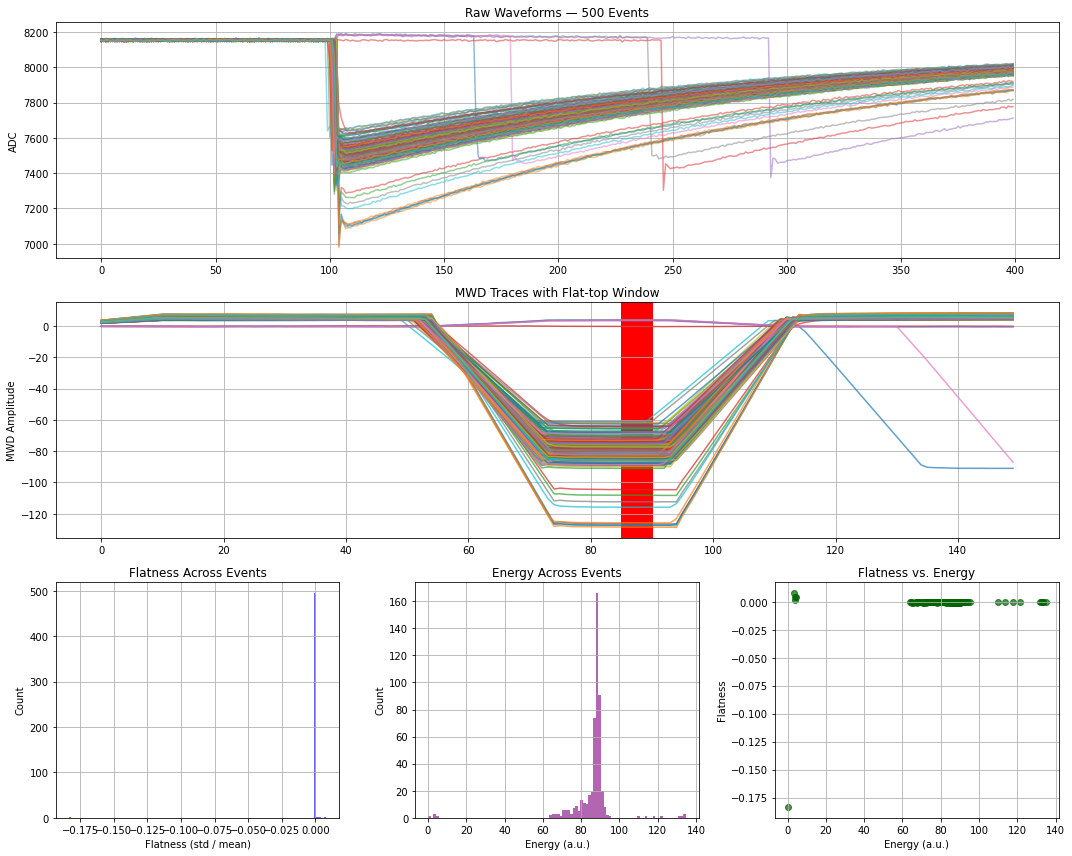

In [8]:
# Pick 10 random events
np.random.seed(42)
sample_indices = np.random.choice(len(waveforms), 500, replace=False)
plot_mwd_batch_diagnostics(sample_indices, waveforms, params_c4_reference)

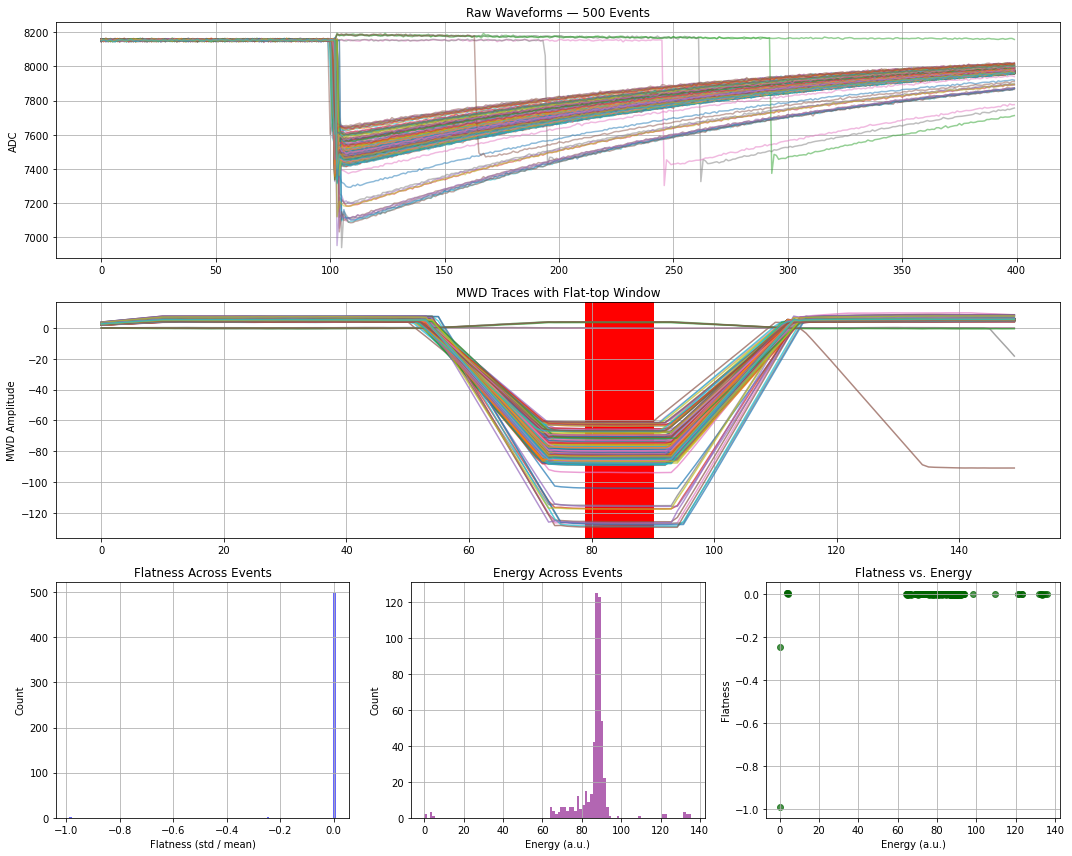

In [11]:
params_new = {
    "sampling": 10.0,
    "smoothing_L": 200.0,
    "MWD_length": 400.0,
    "decay_time": 2300.0,
    "MWD_trace_start": 500.0,
    "MWD_trace_stop": 2000.0,
    "MWD_amp_start": 1290.0,
    "MWD_amp_stop": 1400.0,
    "MWD_baseline_start": 500.0,
    "MWD_baseline_stop": 650.0,
}
sample_indices = np.random.choice(len(waveforms), 500, replace=False)
plot_mwd_batch_diagnostics(sample_indices, waveforms, params_new)

In [13]:
from scipy.optimize import curve_fit
def gaussian(x, A, mean, sigma):
    return A * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_energy_spectrum(energies, bins=200):
    counts, edges = np.histogram(energies, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2

    rms = np.std(energies)
    peak = centers[np.argmax(counts)]
    mask = (centers > peak - 1 * rms) & (centers < peak + 1 * rms)

    x_fit = centers[mask]
    y_fit = counts[mask]

    try:
        A0 = max(y_fit)
        sigma0 = rms
        popt, _ = curve_fit(
            gaussian,
            x_fit,
            y_fit,
            p0=[A0, peak, sigma0],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf])  # force sigma ≥ 0
        )
        A, mean, sigma = popt
        resolution = sigma / mean * 100
        return centers, counts, mean, sigma, resolution
    except Exception as e:
        print(f"Fit failed: {e}")
        return centers, counts, None, None, None

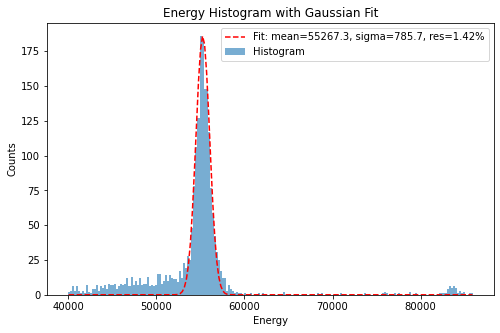

 Fit result: mean=55267.3, sigma=785.7, resolution=1.42%


In [14]:
#  Plot histogram and fit
x, y, mean, sigma, res = fit_energy_spectrum(original_energies)

plt.figure(figsize=(8, 5))
plt.bar(x, y, width=x[1] - x[0], alpha=0.6, label="Histogram")
if mean is not None:
    plt.plot(x, gaussian(x, max(y), mean, sigma), 'r--', label=f"Fit: mean={mean:.1f}, sigma={sigma:.1f}, res={res:.2f}%")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.legend()
plt.title("Energy Histogram with Gaussian Fit")
plt.show()

if mean is not None:
    print(f" Fit result: mean={mean:.1f}, sigma={sigma:.1f}, resolution={res:.2f}%")
else:
    print(" Fit failed — trying expanded window")


In [45]:
def optuna_objective_mwd_decay(trial):
    MWD_length = trial.suggest_float("MWD_length", 500.0, 1000.0)
    decay_time = trial.suggest_float("decay_time", 2000.0, 20000.0)

    params = params_c4_reference.copy()
    params["MWD_length"] = MWD_length
    params["decay_time"] = decay_time

    np.random.seed(0)
    sample_idx = np.random.choice(len(waveforms), size=1000, replace=False)

    energies = []
    flatnesses = []

    for i in sample_idx:
        _, energy, flat = MWD(waveforms[i], params)
        if not np.isnan(energy):
            energies.append(energy)
            flatnesses.append(flat)

    energies = np.array(energies)
    if len(energies) < 100:
        return 1e6

    x, y, mean, sigma, res = fit_energy_spectrum(energies)
    if res is None or sigma <= 0 or res > 100:
        return 1e6

    trial.set_user_attr("resolution", res)
    trial.set_user_attr("flatness_mean", np.nanmean(flatnesses))
    trial.set_user_attr("MWD_length", MWD_length)
    trial.set_user_attr("decay_time", decay_time)

    return res


In [9]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize")
from tqdm.notebook import tqdm

# Create tqdm bar manually
n_trials = 500
pbar = tqdm(total=n_trials)

def update_progress(study, trial):
    pbar.update(1)

study.optimize(optuna_objective_mwd_decay, n_trials=n_trials, callbacks=[update_progress])


  0%|          | 0/500 [00:00<?, ?it/s]

In [27]:
def plot_optimization_diagnostics(study):
    mwd_lengths, decay_times, resolutions, flatnesses = [], [], [], []

    for t in study.trials:
        if t.value < 1e5 and "flatness_mean" in t.user_attrs:
            mwd_lengths.append(t.user_attrs["MWD_length"])
            decay_times.append(t.user_attrs["decay_time"])
            resolutions.append(t.value)
            flatnesses.append(t.user_attrs["flatness_mean"])

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0,0].scatter(mwd_lengths, resolutions, c="blue", alpha=0.7)
    axs[0,0].set_xlabel("MWD Length (ns)")
    axs[0,0].set_ylabel("Resolution (%)")
    axs[0,0].set_title("Resolution vs. MWD Length")
    axs[0,0].grid(True)

    axs[0,1].scatter(decay_times, resolutions, c="orange", alpha=0.7)
    axs[0,1].set_xlabel("Decay Time (ns)")
    axs[0,1].set_ylabel("Resolution (%)")
    axs[0,1].set_title("Resolution vs. Decay Time")
    axs[0,1].grid(True)

    axs[1,0].scatter(decay_times, flatnesses, c="red", alpha=0.7)
    axs[1,0].set_xlabel("Decay Time (ns)")
    axs[1,0].set_ylabel("Flatness")
    axs[1,0].set_title("Decay Time vs. Flatness")
    axs[1,0].grid(True)

    axs[1,1].scatter(flatnesses, resolutions, c="green", alpha=0.7)
    axs[1,1].set_xlabel("Flatness")
    axs[1,1].set_ylabel("Resolution (%)")
    axs[1,1].set_title("Flatness vs. Resolution")
    axs[1,1].grid(True)

    plt.tight_layout()
    plt.show()


In [77]:
def compare_energy_spectra(waveforms, best_params, ref_params, sample_size=1000):
    np.random.seed(1)
    idx = np.random.choice(len(waveforms), size=sample_size, replace=False)

    def get_energies(params):
        return [MWD(waveforms[i], params)[1] for i in idx if not np.isnan(MWD(waveforms[i], params)[1])]

    e_best = get_energies(best_params)
    e_ref = get_energies(ref_params)
    e_csv = original_energies[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

    def plot_hist(ax, data, label):
        x, y, m, s, r = fit_energy_spectrum(data)
        ax.bar(x, y, width=x[1]-x[0], alpha=0.5, label=label)
        if m:
            ax.plot(x, gaussian(x, max(y), m, s), 'k--', label=f"sigma={s:.2f}, Res={r:.2f}%")
        ax.set_title(label)
        ax.set_xlabel("Energy")
        ax.legend(); ax.grid(True)
        return r

    r_csv = plot_hist(axs[0], e_csv, "Energy from File")
    r_ref = plot_hist(axs[1], e_ref, "MWD (Reference Params)")
    r_best = plot_hist(axs[2], e_best, "MWD (Optimized Params)")

    plt.tight_layout()
    plt.show()

    print(f"CSV File Resolution:     {r_csv:.2f}%")
    print(f"Reference MWD Resolution:{r_ref:.2f}%")
    print(f"Optimized MWD Resolution:{r_best:.2f}%")


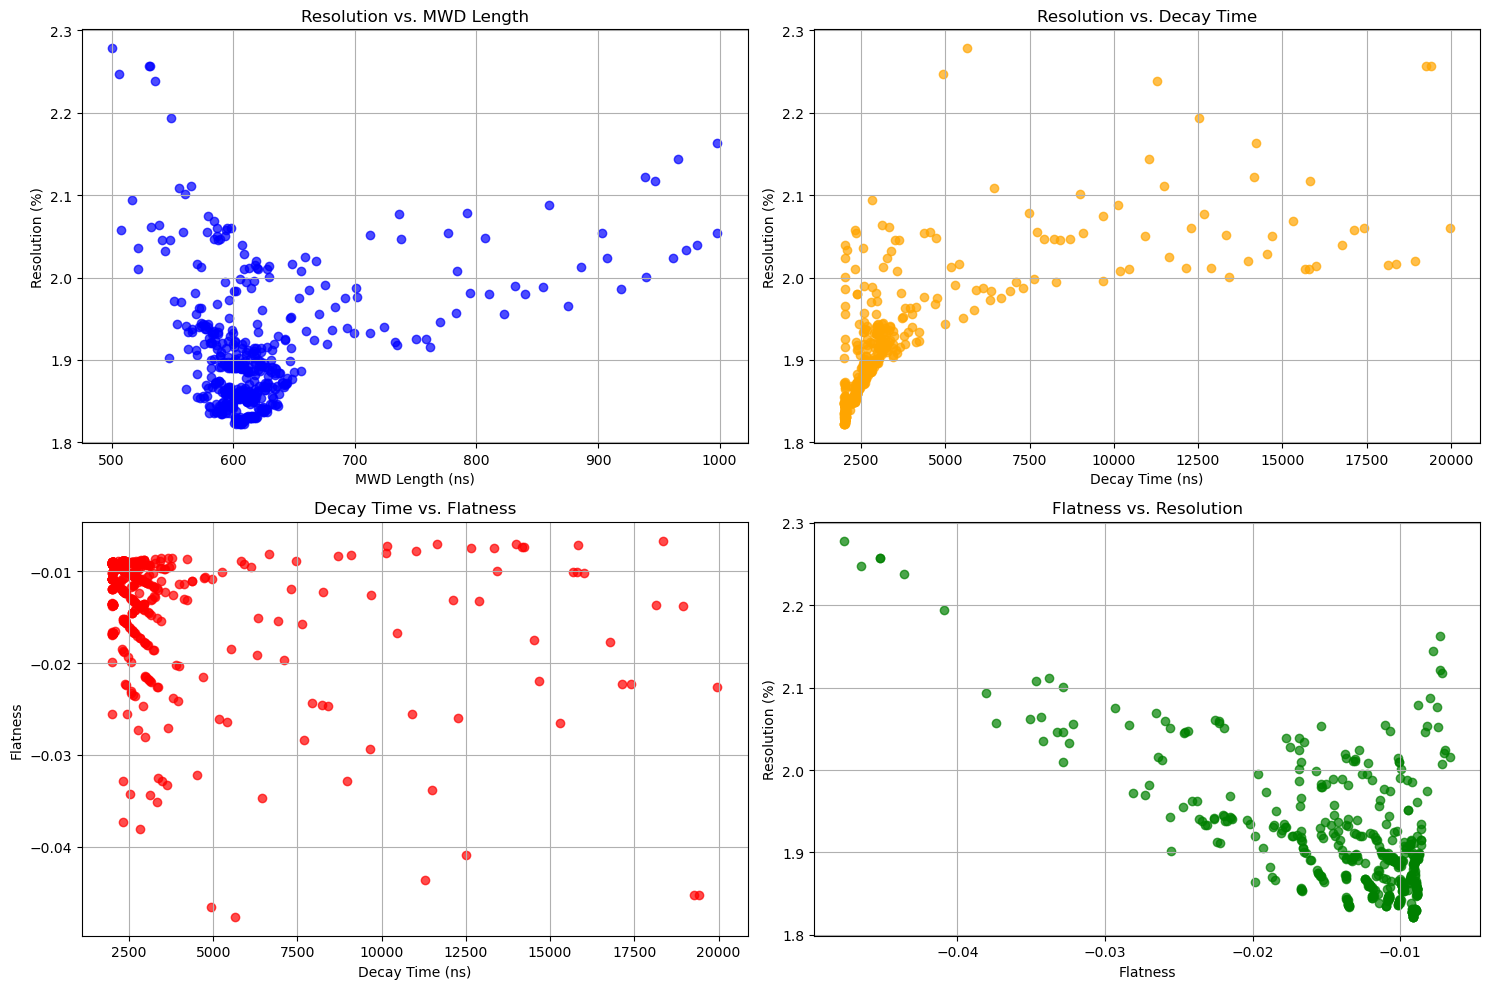

In [29]:
# Plot 3-panel diagnostic
plot_optimization_diagnostics(study)

{'sampling': 10.0, 'smoothing_L': 500.0, 'MWD_length': 602.6136133714218, 'decay_time': 2000.6654744722064, 'MWD_trace_start': 3000.0, 'MWD_trace_stop': 5000.0, 'MWD_amp_start': 4100.0, 'MWD_amp_stop': 4200.0, 'MWD_baseline_start': 3000.0, 'MWD_baseline_stop': 3300.0}


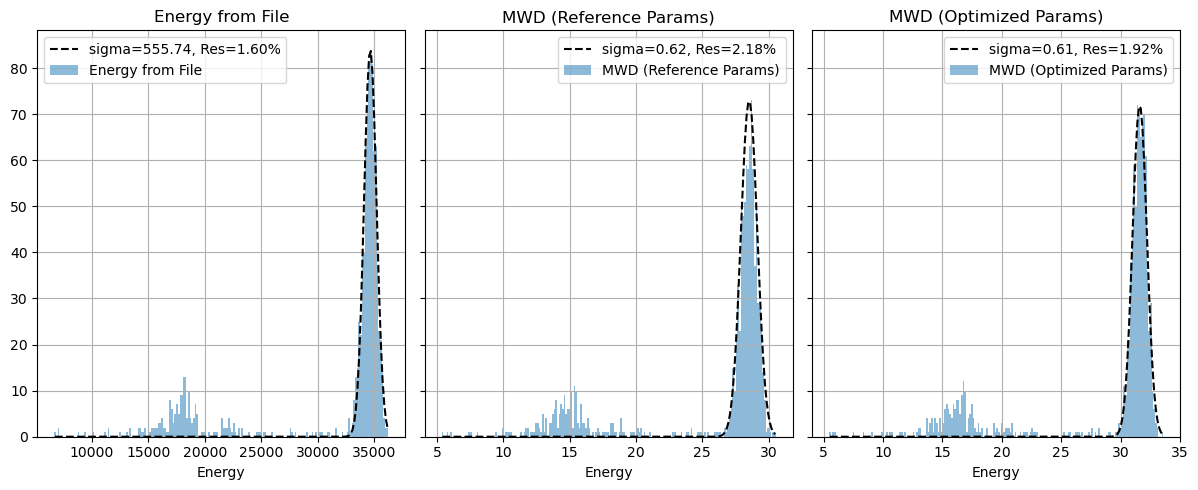

CSV File Resolution:     1.60%
Reference MWD Resolution:2.18%
Optimized MWD Resolution:1.92%


In [13]:
# Compare energy spectra
best_params = params_c4_reference.copy()
best_params.update(study.best_params)
print(best_params)
compare_energy_spectra(waveforms, best_params, params_c4_reference)

In [30]:
def optuna_objective_decay_only(trial):
    decay_time = trial.suggest_float("decay_time", 1000.0, 5000.0)

    params = params_c4_reference.copy()
    params["MWD_length"] = 600.0  # fixed
    params["decay_time"] = decay_time

    np.random.seed(0)
    sample_idx = np.random.choice(len(waveforms), size=1000, replace=False)

    energies = []
    flatnesses = []
    for i in sample_idx:
        _, energy, flat = MWD(waveforms[i], params)
        if not np.isnan(energy):
            energies.append(energy)
            flatnesses.append(flat)

    energies = np.array(energies)
    if len(energies) < 100:
        return 1e6

    try:
        x, y, mean, sigma, res = fit_energy_spectrum(energies)
        if res is None or sigma <= 0 or res > 100:
            return 1e6
        trial.set_user_attr("resolution", res)
        trial.set_user_attr("decay_time", decay_time)
        trial.set_user_attr("flatness_mean", np.nanmean(flatnesses))
        return res
    except:
        return 1e6


In [31]:
from tqdm.notebook import tqdm

n_trials = 50
pbar = tqdm(total=n_trials)

study_decay = optuna.create_study(direction="minimize")

def update_progress(study, trial):
    pbar.update(1)

study_decay.optimize(optuna_objective_decay_only, n_trials=n_trials, callbacks=[update_progress])


  0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
def plot_decay_scan_diagnostics(study):
    decay_times = []
    resolutions = []
    flatnesses = []

    for t in study.trials:
        if t.value < 1e5 and "flatness_mean" in t.user_attrs:
            decay_times.append(t.user_attrs["decay_time"])
            resolutions.append(t.value)
            flatnesses.append(t.user_attrs["flatness_mean"])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Panel 1: Resolution vs. Decay Time
    axs[0].scatter(decay_times, resolutions, c="orange", alpha=0.7)
    axs[0].set_xlabel("Decay Time (ns)")
    axs[0].set_ylabel("Resolution (%)")
    axs[0].set_title("Resolution vs. Decay Time")
    axs[0].grid(True)

    # Panel 2: Flatness vs. Resolution
    axs[1].scatter(flatnesses, resolutions, c="green", alpha=0.7)
    axs[1].set_xlabel("Flatness (std/mean)")
    axs[1].set_ylabel("Resolution (%)")
    axs[1].set_title("Flatness vs. Resolution")
    axs[1].grid(True)

    # Panel 3: Flatness vs. Decay Time
    axs[2].scatter(decay_times, flatnesses, c="blue", alpha=0.7)
    axs[2].set_xlabel("Decay Time (ns)")
    axs[2].set_ylabel("Flatness (std/mean)")
    axs[2].set_title("Flatness vs. Decay Time")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

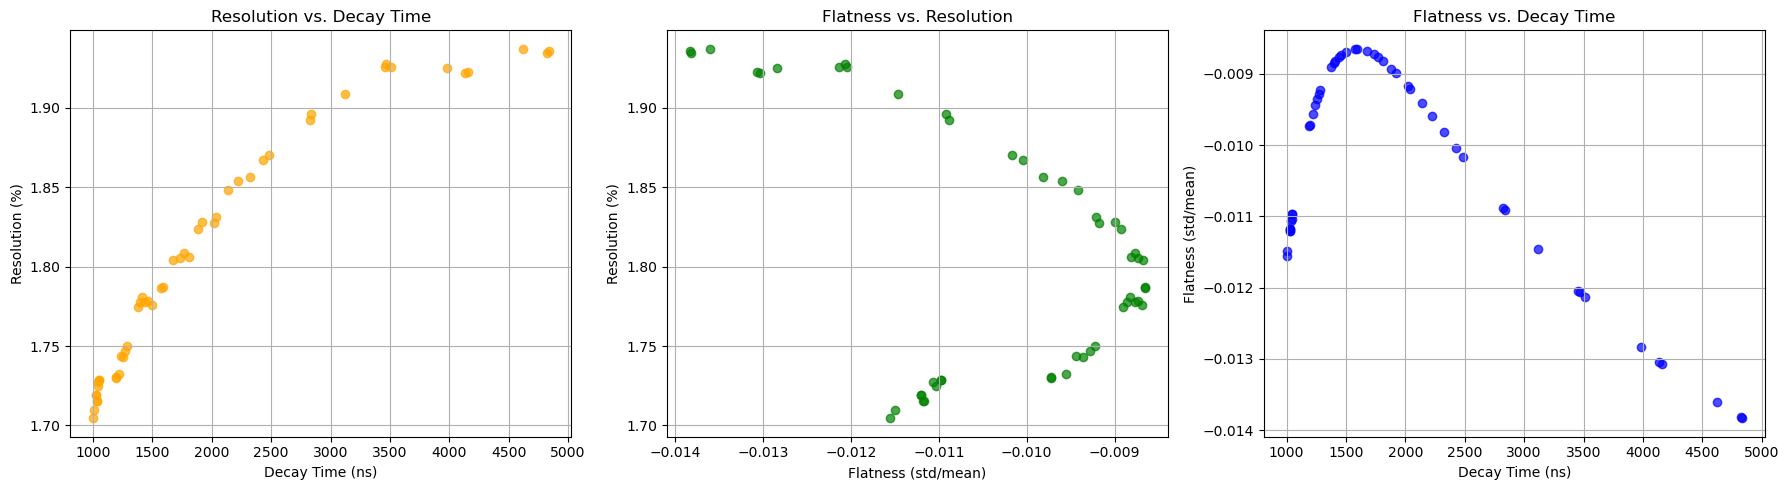

In [33]:
plot_decay_scan_diagnostics(study_decay)

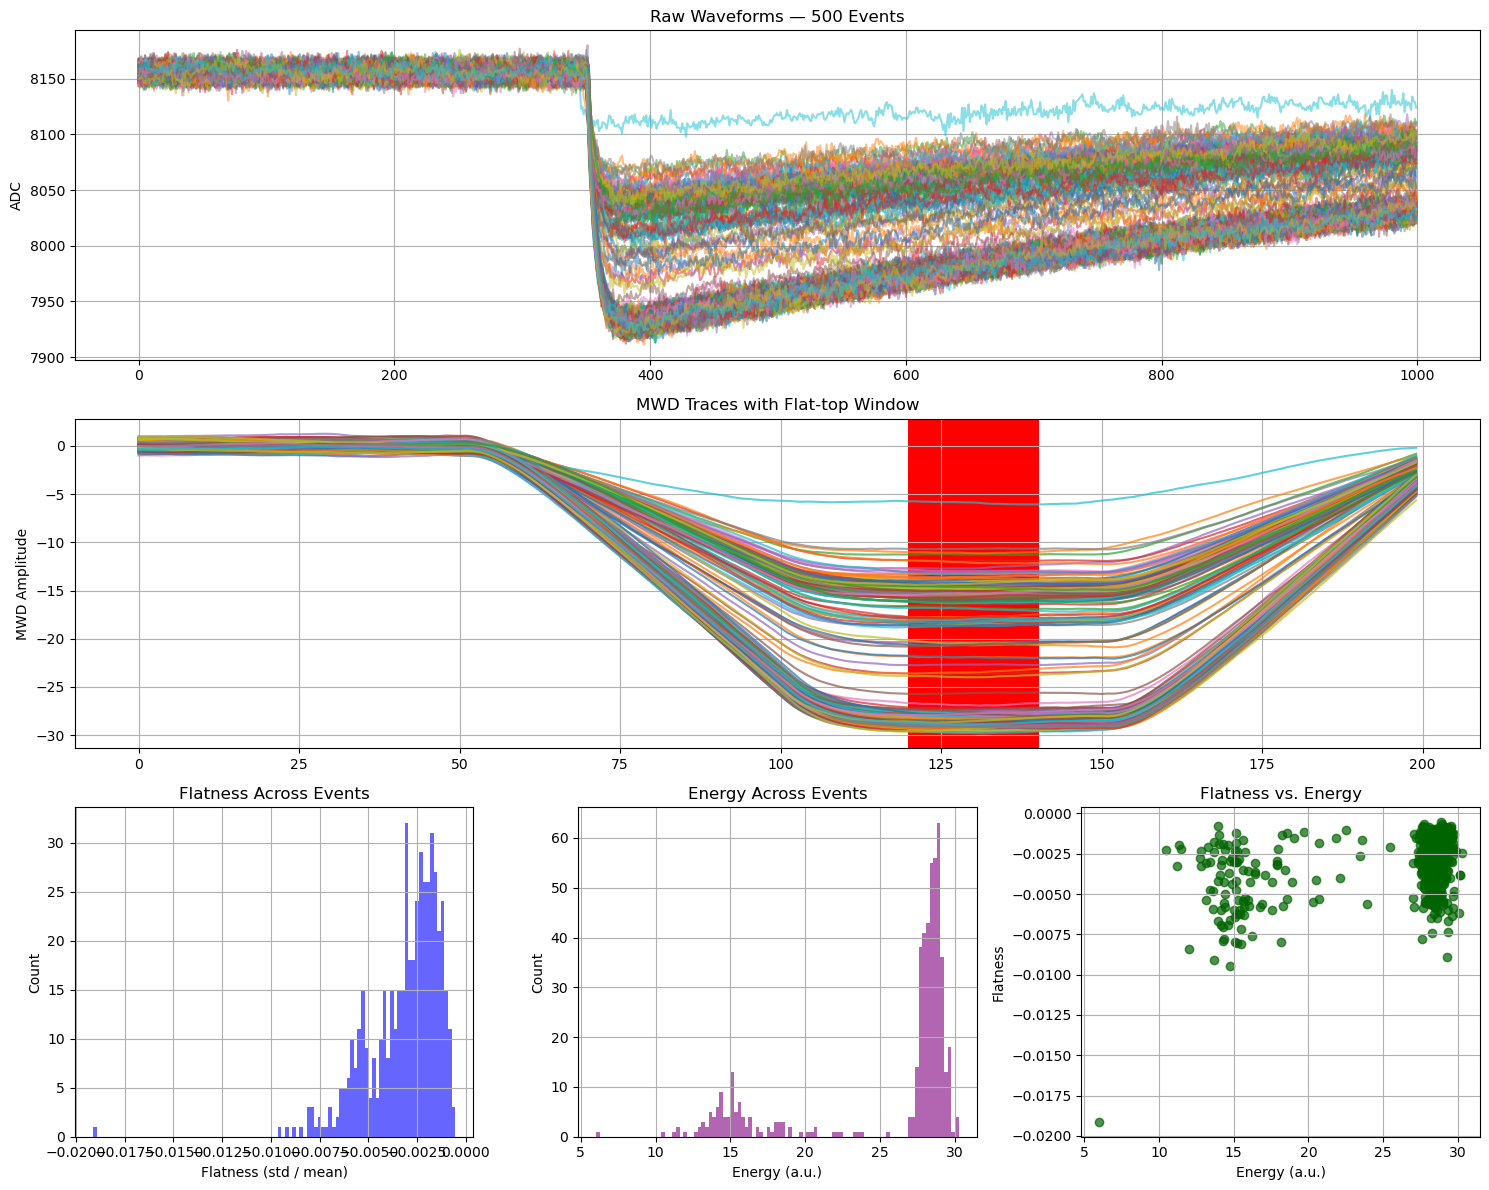

In [53]:
params_new = {
    "sampling": 10.0,
    "smoothing_L": 500.0,
    "MWD_length": 1000.0,
    "decay_time": 17000.0,
    "MWD_trace_start": 3000.0,
    "MWD_trace_stop": 5000.0,
    "MWD_amp_start": 4200.0,
    "MWD_amp_stop": 4400.0,
    "MWD_baseline_start": 3000.0,
    "MWD_baseline_stop": 3300.0,
}
sample_indices = np.random.choice(len(waveforms), 500, replace=False)
plot_mwd_batch_diagnostics(sample_indices, waveforms, params_new)

In [58]:
def optuna_objective_mwd_wdw(trial):
    smoothing_L = trial.suggest_float("smoothing_L", 200.0, 2000.0)
    MWD_amp_start = trial.suggest_float("MWD_amp_start", 4000.0, 4500.0)
    MWD_amp_length = trial.suggest_float("MWD_amp_length", 100.0, 5000-MWD_amp_start)
    MWD_amp_stop = MWD_amp_start + MWD_amp_length

    params = params_new.copy()
    params["smoothing_L"] = smoothing_L
    params["MWD_amp_start"] = MWD_amp_start
    params["MWD_amp_stop"] = MWD_amp_stop

    np.random.seed(0)
    sample_idx = np.random.choice(len(waveforms), size=1000, replace=False)

    energies = []
    flatnesses = []

    for i in sample_idx:
        _, energy, flat = MWD(waveforms[i], params)
        if not np.isnan(energy):
            energies.append(energy)
            flatnesses.append(flat)

    energies = np.array(energies)
    if len(energies) < 100:
        return 1e6

    x, y, mean, sigma, res = fit_energy_spectrum(energies)
    if res is None or sigma <= 0 or res > 100:
        return 1e6

    trial.set_user_attr("resolution", res)
    trial.set_user_attr("flatness_mean", np.nanmean(flatnesses))
    trial.set_user_attr("smoothing_L", smoothing_L)
    trial.set_user_attr("MWD_amp_start", MWD_amp_start)
    trial.set_user_attr("MWD_amp_stop", MWD_amp_stop)

    return res

In [62]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize")
from tqdm.notebook import tqdm

# Create tqdm bar manually
n_trials = 1000
pbar = tqdm(total=n_trials)

def update_progress(study, trial):
    pbar.update(1)

study.optimize(optuna_objective_mwd_wdw, n_trials=n_trials, callbacks=[update_progress])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
def plot_mwd_window_diagnostics(study):
    smoothing_Ls = []
    amp_starts = []
    amp_stops = []
    amp_lengths = []
    resolutions = []

    for t in study.trials:
        if t.value < 1e5 and all(k in t.user_attrs for k in ["smoothing_L", "MWD_amp_start", "MWD_amp_stop"]):
            smoothing_L = t.user_attrs["smoothing_L"]
            amp_start = t.user_attrs["MWD_amp_start"]
            amp_stop = t.user_attrs["MWD_amp_stop"]
            res = t.user_attrs["resolution"]

            smoothing_Ls.append(smoothing_L)
            amp_starts.append(amp_start)
            amp_stops.append(amp_stop)
            amp_lengths.append(amp_stop - amp_start)
            resolutions.append(res)

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    axs[0, 0].scatter(smoothing_Ls, resolutions, c="blue", alpha=0.7)
    axs[0, 0].set_xlabel("Smoothing L (ns)")
    axs[0, 0].set_ylabel("Resolution (%)")
    axs[0, 0].set_title("Resolution vs. Smoothing L")
    axs[0, 0].grid(True)

    axs[0, 1].scatter(amp_starts, resolutions, c="purple", alpha=0.7)
    axs[0, 1].set_xlabel("MWD Amp Start (ns)")
    axs[0, 1].set_ylabel("Resolution (%)")
    axs[0, 1].set_title("Resolution vs. Amp Start")
    axs[0, 1].grid(True)

    axs[1, 0].scatter(amp_stops, resolutions, c="darkorange", alpha=0.7)
    axs[1, 0].set_xlabel("MWD Amp Stop (ns)")
    axs[1, 0].set_ylabel("Resolution (%)")
    axs[1, 0].set_title("Resolution vs. Amp Stop")
    axs[1, 0].grid(True)

    axs[1, 1].scatter(amp_lengths, resolutions, c="green", alpha=0.7)
    axs[1, 1].set_xlabel("MWD Amp Length (ns)")
    axs[1, 1].set_ylabel("Resolution (%)")
    axs[1, 1].set_title("Resolution vs. Amp Length")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

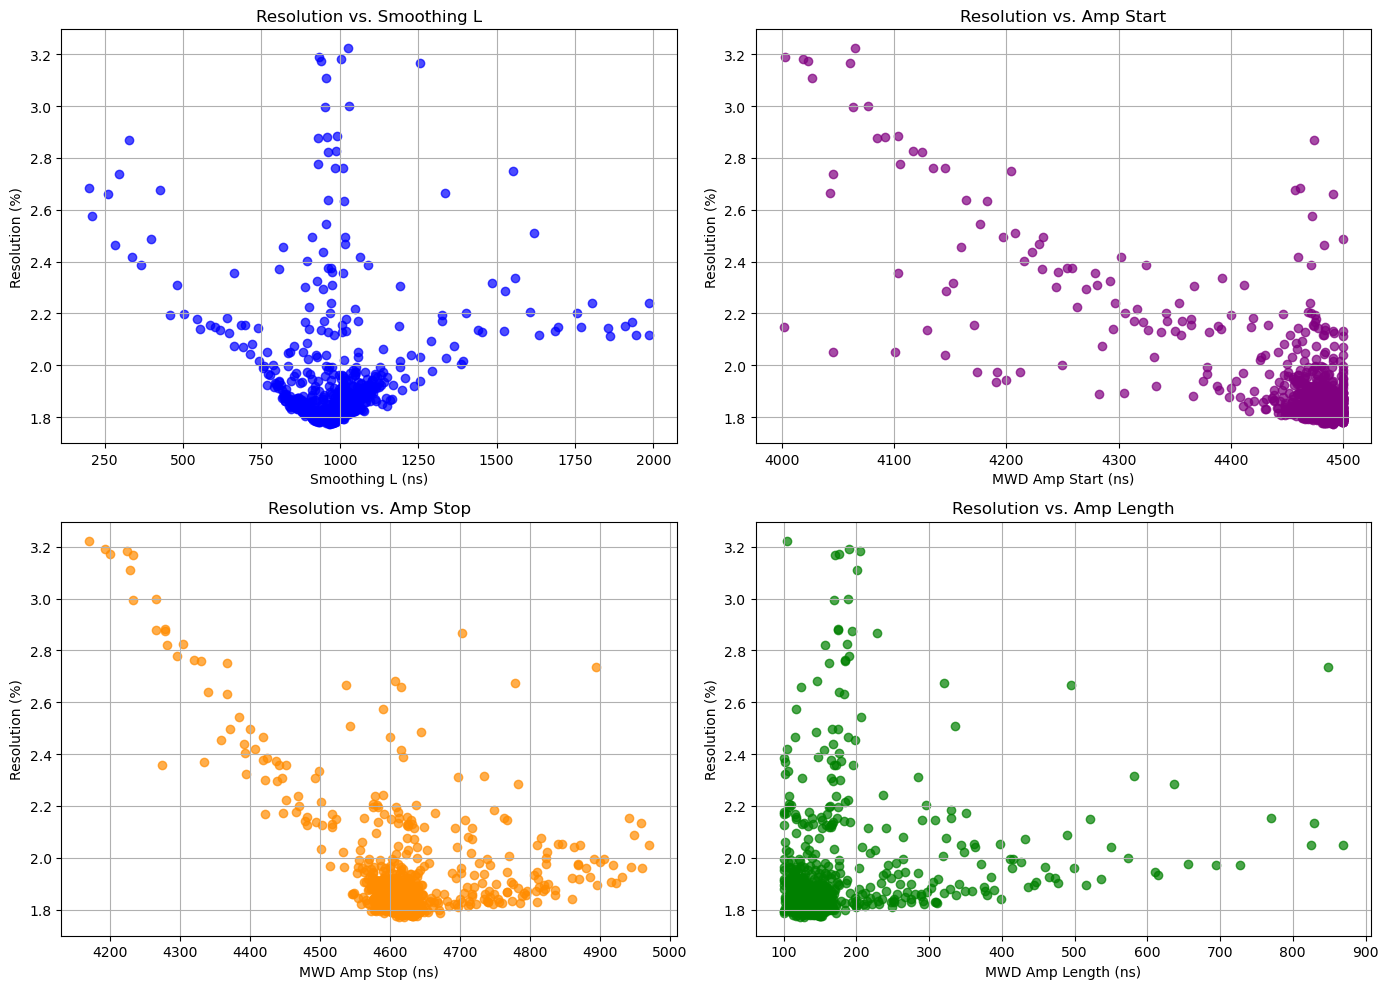

In [64]:
plot_mwd_window_diagnostics(study)

{'sampling': 10.0, 'smoothing_L': 965.7842569186694, 'MWD_length': 1000.0, 'decay_time': 17000.0, 'MWD_trace_start': 3000.0, 'MWD_trace_stop': 5000.0, 'MWD_amp_start': 4490.96391564891, 'MWD_amp_stop': 4613.07493347619, 'MWD_baseline_start': 3000.0, 'MWD_baseline_stop': 3300.0, 'MWD_amp_length': 122.11101782728039}


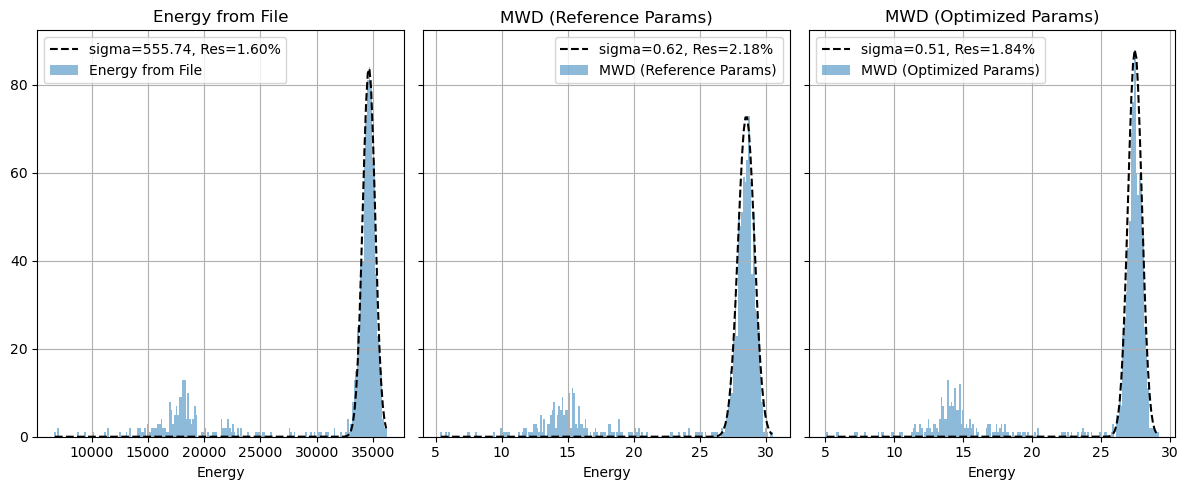

CSV File Resolution:     1.60%
Reference MWD Resolution:2.18%
Optimized MWD Resolution:1.84%


In [80]:
# Compare energy spectra
best_params = params_new.copy()
best_params.update(study.best_params)
best_params["MWD_amp_stop"] = study.best_params["MWD_amp_start"]+study.best_params["MWD_amp_length"]
print(best_params)
compare_energy_spectra(waveforms, best_params, params_c4_reference)

In [81]:
def optuna_objective_decay_only(trial):
    decay_time = trial.suggest_float("decay_time", 1000.0, 30000.0)

    params = best_params.copy()
    params["decay_time"] = decay_time

    np.random.seed(0)
    sample_idx = np.random.choice(len(waveforms), size=1000, replace=False)

    energies, flatnesses = [], []
    for i in sample_idx:
        _, energy, flat = MWD(waveforms[i], params)
        if not np.isnan(energy):
            energies.append(energy)
            flatnesses.append(flat)

    energies = np.array(energies)
    if len(energies) < 100:
        return 1e6

    x, y, mean, sigma, res = fit_energy_spectrum(energies)
    if res is None or sigma <= 0 or res > 100:
        return 1e6

    trial.set_user_attr("resolution", res)
    trial.set_user_attr("decay_time", decay_time)
    trial.set_user_attr("flatness_mean", np.nanmean(flatnesses))

    return res


In [82]:
n_trials = 50
pbar = tqdm(total=n_trials)

study_decay = optuna.create_study(direction="minimize")

def update_progress(study, trial):
    pbar.update(1)
print(best_params)
study_decay.optimize(optuna_objective_decay_only, n_trials=n_trials, callbacks=[update_progress])

  0%|          | 0/50 [00:00<?, ?it/s]

{'sampling': 10.0, 'smoothing_L': 965.7842569186694, 'MWD_length': 1000.0, 'decay_time': 17000.0, 'MWD_trace_start': 3000.0, 'MWD_trace_stop': 5000.0, 'MWD_amp_start': 4490.96391564891, 'MWD_amp_stop': 4613.07493347619, 'MWD_baseline_start': 3000.0, 'MWD_baseline_stop': 3300.0, 'MWD_amp_length': 122.11101782728039}


In [83]:
def plot_decay_diagnostics(study):
    decay_times, resolutions, flatnesses = [], [], []

    for t in study.trials:
        if t.value < 1e5 and "flatness_mean" in t.user_attrs:
            decay_times.append(t.user_attrs["decay_time"])
            resolutions.append(t.value)
            flatnesses.append(t.user_attrs["flatness_mean"])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(decay_times, resolutions, c="orange", alpha=0.7)
    axs[0].set_xlabel("Decay Time (ns)")
    axs[0].set_ylabel("Resolution (%)")
    axs[0].set_title("Resolution vs. Decay Time")
    axs[0].grid(True)

    axs[1].scatter(decay_times, flatnesses, c="green", alpha=0.7)
    axs[1].set_xlabel("Decay Time (ns)")
    axs[1].set_ylabel("Flatness (std/mean)")
    axs[1].set_title("Flatness vs. Decay Time")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


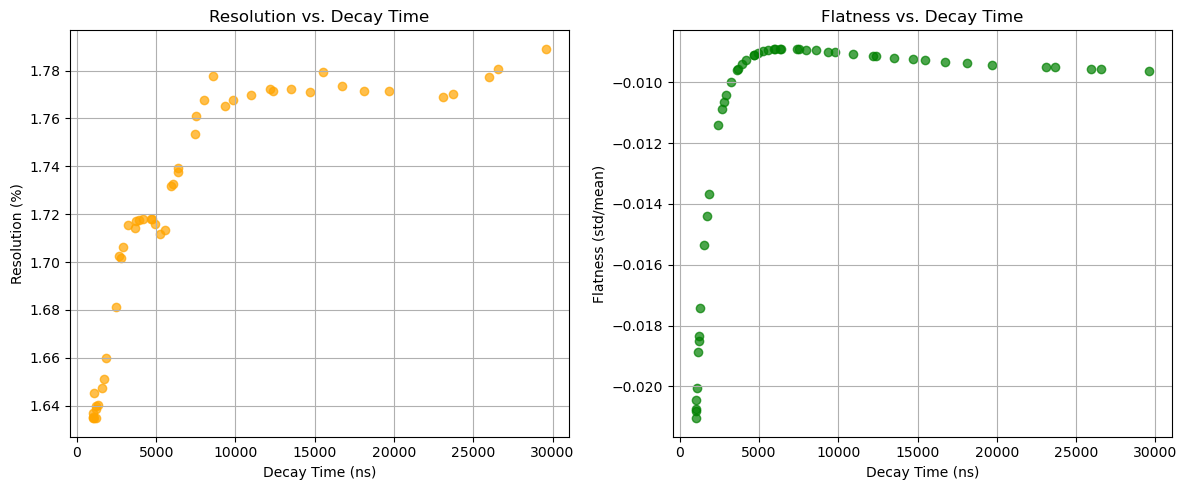

In [84]:
plot_decay_diagnostics(study_decay)

{'sampling': 10.0, 'smoothing_L': 500.0, 'MWD_length': 1000.0, 'decay_time': 1351.4804497373425, 'MWD_trace_start': 3000.0, 'MWD_trace_stop': 5000.0, 'MWD_amp_start': 4200.0, 'MWD_amp_stop': 4400.0, 'MWD_baseline_start': 3000.0, 'MWD_baseline_stop': 3300.0}


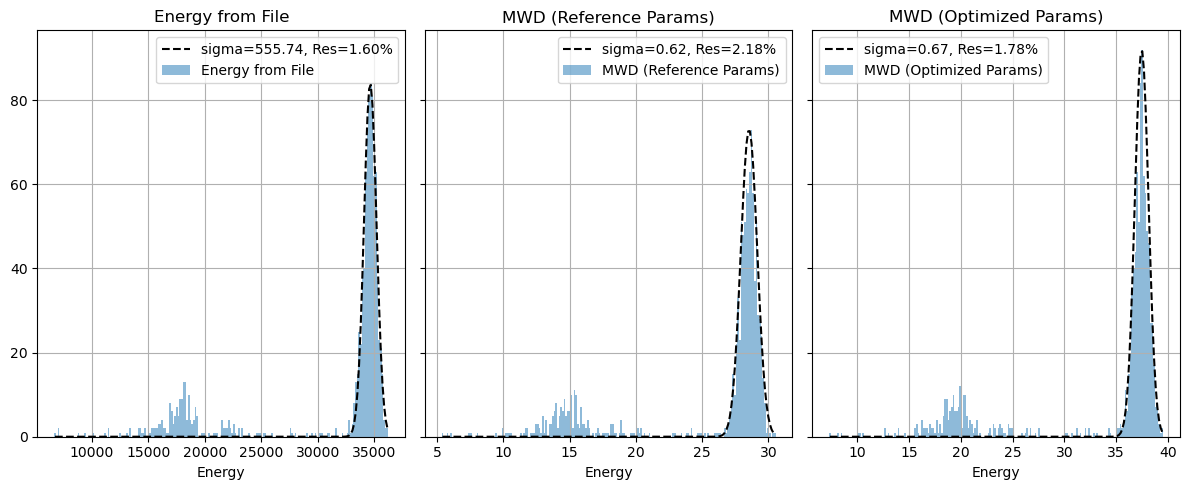

CSV File Resolution:     1.60%
Reference MWD Resolution:2.18%
Optimized MWD Resolution:1.78%


In [79]:
# Start from window-optimized best parameters
final_best_params = best_params.copy()  # This already has smoothing_L, MWD_amp_start/stop etc.
final_best_params.update(study_decay.best_params)  # Only updates decay_time

print(final_best_params)
compare_energy_spectra(waveforms, final_best_params, params_c4_reference)